<a href="https://colab.research.google.com/github/peeyushsinghal/EVA8/blob/main/S4-Assignment-Solution/EVA8_S4_Experiment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Objective / Target of Experiment 1
**Objective / Target**
*   Initial Setup and Model
*   Getting the model correct
* Very basic model

**Results**

* Parameters: 6,379,786
* Best Train Accuracy: 99.91 %
* Best Test Accuracy: 99.28 %

**Analysis**

* Large but working model
* Overfitting (train - test accuracy) > 0

**Next Steps**

* Reduce Number of Params
* Remove overfitting

# Importing Libraries

In [1]:
import torch
from torchvision import datasets,transforms
%matplotlib inline
import matplotlib.pyplot as plt # for visualizing images
import random # for random image index
import torch.nn as nn # for network
import torch.nn.functional as F # for forward method
import torch.optim as optim # for optimizer
!pip install torchsummary
from torchsummary import summary # for model summary and params
from tqdm import tqdm # for beautiful model training updates

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Seed and Cuda

In [2]:
# check for cuda
cuda = torch.cuda.is_available()
print (f' Cuda Status : {cuda}')

# setting seed
SEED = 42 # arbit seed, why 42 - because in hitch hikers guide to galaxy it is answer to everything
# torch.cuda.seed(SEED) 
torch.cuda.manual_seed_all(SEED) if cuda else torch.manual_seed(SEED)

 Cuda Status : True


# Data Transformations

In [3]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(), # converts to tesnor
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),# converts to tesnor
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train / Test Split

In [4]:
train = datasets.MNIST('./data', # directory where data needs to be stored
                       train=True, # get the training portion of the dataset
                       download=True, # downloads
                       transform=train_transforms)
test = datasets.MNIST('./data', 
                      train=False, 
                      download=True, 
                      transform=test_transforms)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



## Data Loader

In [5]:
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory = True) if cuda else dict(shuffle=True, batch_size=64)

train_loader = torch.utils.data.DataLoader(
    dataset=train,# train dataset
    **dataloader_args # the dataloader arguments change dependent on cuda is available or not
    )

test_loader = torch.utils.data.DataLoader(
    dataset = test,# test dataset 
    **dataloader_args # the dataloader arguments change dependent on cuda is available or not
)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Checking Dataloader

torch.Size([128, 1, 28, 28])
torch.Size([128])


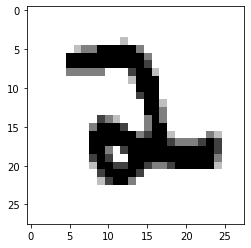

In [6]:
images, labels  = next(iter(train_loader))
print(images.shape)
print(labels.shape)
# printing random image and seeing
plt.imshow(images[random.randint(0,len(images))].numpy().squeeze(), cmap='gray_r')

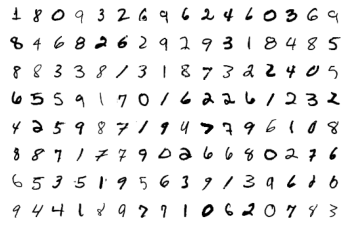

In [7]:
# Looking at more images
figure = plt.figure()
for index in range(1, len(images) + 1): # assumption: batch size would be atleast 8
    plt.subplot(8, int(len(images)/8), index)
    plt.axis('off')
    plt.imshow(images[index-1].numpy().squeeze(), cmap='gray_r')

# Model

In [8]:
class Network(nn.Module):
  def __init__(self):
    super(Network,self).__init__() # extending super class method

    # Conv Block 1
    self.conv1 = nn.Conv2d(1,32,3, padding=1) # In- 1x28x28, Out- 32x28x28, RF- 3x3, Jump_in -1, Jump_out -1
    self.conv2 = nn.Conv2d(32,64,3, padding=1) # In- 32x28x28, Out- 64x28x28, RF- 5x5, Jump_in -1, Jump_out -1
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # In- 64x28x28, Out- 64x14x14, RF- 6x6, Jump_in -1, Jump_out -2

    # Conv Block 2
    self.conv3 = nn.Conv2d(64,128,3, padding=1) # In- 64x14x14, Out- 128x14x14, RF- 10x10, Jump_in -2, Jump_out -2
    self.conv4 = nn.Conv2d(128,256,3, padding=1) # In- 128x14x14, Out- 256x14x14, RF- 14x14, Jump_in -2, Jump_out -2
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # In- 256x14x14, Out- 256x7x7, RF- 16x16, Jump_in -2, Jump_out -4

    # Conv Block 3
    self.conv5 = nn.Conv2d(256,512,3, padding=0) # In- 256x7x7, Out- 512x5x5, RF- 18x18, Jump_in -4, Jump_out -4
    self.conv6 = nn.Conv2d(512,1024,3, padding=0) # In- 512x5x5, Out- 1024x3x3, RF- 26x26, Jump_in -4, Jump_out -4
    self.conv7 = nn.Conv2d(1024,10,3) # In- 1024x3x3, Out- 10x1x1, RF- 34x34, Jump_in -4, Jump_out -4

  
  def forward(self,x):

    # Block 1
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = F.relu(self.pool1(x))

    # Block 2
    x = F.relu(self.conv3(x))
    x = F.relu(self.conv4(x))
    x = F.relu(self.pool2(x))

    # Block 3
    x = F.relu(self.conv5(x))
    x = F.relu(self.conv6(x))
    x = self.conv7(x)

    # Flattening
    x = x.view(-1,10)
    return F.log_softmax(x,dim=-1)

# model = Network()
# print(model)

## Model Params

In [9]:
device = torch.device("cuda" if cuda else "cpu")
print(device)
model = Network().to(device)
# print(model)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
            Conv2d-2           [-1, 64, 28, 28]          18,496
         MaxPool2d-3           [-1, 64, 14, 14]               0
            Conv2d-4          [-1, 128, 14, 14]          73,856
            Conv2d-5          [-1, 256, 14, 14]         295,168
         MaxPool2d-6            [-1, 256, 7, 7]               0
            Conv2d-7            [-1, 512, 5, 5]       1,180,160
            Conv2d-8           [-1, 1024, 3, 3]       4,719,616
            Conv2d-9             [-1, 10, 1, 1]          92,170
Total params: 6,379,786
Trainable params: 6,379,786
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 1.51
Params size (MB): 24.34
Estimated Total Size (MB): 25.85
--------------------------------

# Training and Testing

## Training

In [10]:
# Training Function
train_losses = [] # to capture train losses over training epochs
train_accuracy = [] # to capture train accuracy over training epochs

def train(model,device, train_loader,optimizer,epoch):
  model.train() # setting the model in training mode
  pbar = tqdm(train_loader) # putting the iterator in pbar
  correct = 0 # for accuracy numerator
  processed =0 # for accuracy denominator

  for batch_idx, (images,labels) in enumerate(pbar):
    images, labels = images.to(device),labels.to(device)#sending data to CPU or GPU as per device
    optimizer.zero_grad() # setting gradients to zero to avoid accumulation

    y_preds = model(images) # forward pass, result captured in y_preds (plural as there are many images in a batch)
    # the predictions are in one hot vector

    loss = F.nll_loss(y_preds,labels) # capturing loss
    train_losses.append(loss) # to capture loss over many epochs

    loss.backward() # backpropagation
    optimizer.step() # updating the params

    preds = y_preds.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += preds.eq(labels.view_as(preds)).sum().item()
    processed += len(images)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_accuracy.append(100*correct/processed)


## Test

In [11]:
# Test Function
test_losses = [] # to capture test losses 
test_accuracy = [] # to capture test accuracy 

def test(model,device, test_loader):
  model.eval() # setting the model in evaluation mode
  test_loss = 0
  correct = 0 # for accuracy numerator

  with torch.no_grad():
    for (images,labels) in test_loader:
      images, labels = images.to(device),labels.to(device)#sending data to CPU or GPU as per device
      outputs = model(images) # forward pass, result captured in outputs (plural as there are many images in a batch)
      # the outputs are in batch size x one hot vector 

      test_loss = F.nll_loss(outputs,labels, reduction='sum').item()  # sum up batch loss
      preds = outputs.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
      correct += preds.eq(labels.view_as(preds)).sum().item()

    test_loss /= len(test_loader.dataset) # average test loss
    test_losses.append(test_loss) # to capture loss over many batches

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

    test_accuracy.append(100*correct/len(test_loader.dataset))


## Execution

In [21]:
model =  Network().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=0.041518159210681915 Batch_id=468 Accuracy=88.36: 100%|██████████| 469/469 [00:17<00:00, 26.25it/s]



Test set: Average loss: 0.0000, Accuracy: 9831/10000 (98.31%)

EPOCH: 1


Loss=0.004759416915476322 Batch_id=468 Accuracy=98.37: 100%|██████████| 469/469 [00:18<00:00, 25.85it/s]



Test set: Average loss: 0.0000, Accuracy: 9891/10000 (98.91%)

EPOCH: 2


Loss=0.025464938953518867 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:19<00:00, 24.53it/s]



Test set: Average loss: 0.0000, Accuracy: 9866/10000 (98.66%)

EPOCH: 3


Loss=0.0027345248963683844 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:18<00:00, 25.56it/s]



Test set: Average loss: 0.0000, Accuracy: 9883/10000 (98.83%)

EPOCH: 4


Loss=0.05620245635509491 Batch_id=468 Accuracy=99.40: 100%|██████████| 469/469 [00:18<00:00, 24.86it/s]



Test set: Average loss: 0.0000, Accuracy: 9913/10000 (99.13%)

EPOCH: 5


Loss=0.002997518749907613 Batch_id=468 Accuracy=99.55: 100%|██████████| 469/469 [00:18<00:00, 25.88it/s]



Test set: Average loss: 0.0000, Accuracy: 9908/10000 (99.08%)

EPOCH: 6


Loss=0.00014058567467145622 Batch_id=468 Accuracy=99.64: 100%|██████████| 469/469 [00:18<00:00, 25.26it/s]



Test set: Average loss: 0.0000, Accuracy: 9906/10000 (99.06%)

EPOCH: 7


Loss=0.01404644176363945 Batch_id=468 Accuracy=99.73: 100%|██████████| 469/469 [00:18<00:00, 25.36it/s]



Test set: Average loss: 0.0000, Accuracy: 9920/10000 (99.20%)

EPOCH: 8


Loss=0.05885494127869606 Batch_id=468 Accuracy=99.81: 100%|██████████| 469/469 [00:18<00:00, 25.89it/s]



Test set: Average loss: 0.0000, Accuracy: 9916/10000 (99.16%)

EPOCH: 9


Loss=0.015448507852852345 Batch_id=468 Accuracy=99.79: 100%|██████████| 469/469 [00:18<00:00, 25.66it/s]



Test set: Average loss: 0.0000, Accuracy: 9922/10000 (99.22%)

EPOCH: 10


Loss=0.0007705116295255721 Batch_id=468 Accuracy=99.84: 100%|██████████| 469/469 [00:18<00:00, 25.59it/s]



Test set: Average loss: 0.0000, Accuracy: 9913/10000 (99.13%)

EPOCH: 11


Loss=0.01925574615597725 Batch_id=468 Accuracy=99.90: 100%|██████████| 469/469 [00:18<00:00, 25.49it/s]



Test set: Average loss: 0.0000, Accuracy: 9912/10000 (99.12%)

EPOCH: 12


Loss=0.011285129003226757 Batch_id=468 Accuracy=99.89: 100%|██████████| 469/469 [00:18<00:00, 25.70it/s]



Test set: Average loss: 0.0000, Accuracy: 9928/10000 (99.28%)

EPOCH: 13


Loss=0.019102061167359352 Batch_id=468 Accuracy=99.89: 100%|██████████| 469/469 [00:18<00:00, 25.83it/s]



Test set: Average loss: 0.0000, Accuracy: 9912/10000 (99.12%)

EPOCH: 14


Loss=0.024404050782322884 Batch_id=468 Accuracy=99.91: 100%|██████████| 469/469 [00:18<00:00, 24.72it/s]



Test set: Average loss: 0.0000, Accuracy: 9912/10000 (99.12%)



Text(0.5, 1.0, 'Test Accuracy')

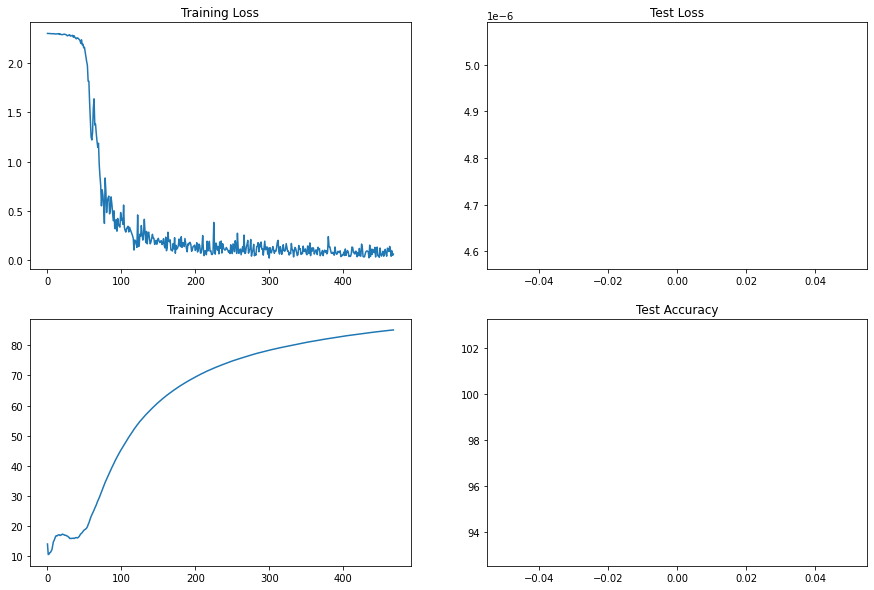

In [20]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot([t.cpu().item() for t in train_losses])
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_accuracy)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_accuracy)
axs[1, 1].set_title("Test Accuracy")